In [30]:
%matplotlib inline

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from __future__ import division
from nilearn import plotting

In [36]:
sns.set_context('poster')

In [15]:
# read vertices, faces and data from vtk file
def read_vtk(file):
    import pandas as pd
    import numpy as np
    # read full file while dropping empty lines 
    vtk_df=pd.read_csv(file, header=None)
    vtk_df=vtk_df.dropna()
    # extract number of vertices and faces
    number_vertices=int(vtk_df[vtk_df[0].str.contains('POINTS')][0].iloc[0].split()[1])
    number_faces=int(vtk_df[vtk_df[0].str.contains('POLYGONS')][0].iloc[0].split()[1])
    # read vertices into df and array
    start_vertices= (vtk_df[vtk_df[0].str.contains('POINTS')].index.tolist()[0])+1
    vertex_df=pd.read_csv(file, skiprows=range(start_vertices), nrows=number_vertices, sep='\s*', header=None)
    if np.array(vertex_df).shape[1]==3:
        vertex_array=np.array(vertex_df)
    # sometimes the vtk format is weird with 9 indices per line, then it has to be reshaped
    elif np.array(vertex_df).shape[1]==9:
        vertex_df=pd.read_csv(file, skiprows=range(start_vertices), nrows=int(number_vertices/3)+1, sep='\s*', header=None)
        vertex_array=np.array(vertex_df.iloc[0:1,0:3])
        vertex_array=np.append(vertex_array, vertex_df.iloc[0:1,3:6], axis=0)
        vertex_array=np.append(vertex_array, vertex_df.iloc[0:1,6:9], axis=0)
        for row in range(1,(int(number_vertices/3)+1)):
            for col in [0,3,6]:
                vertex_array=np.append(vertex_array, np.array(vertex_df.iloc[row:(row+1),col:(col+3)]),axis=0) 
        # strip rows containing nans
        vertex_array=vertex_array[ ~np.isnan(vertex_array) ].reshape(number_vertices,3)
    else:
        print "vertex indices out of shape"
    # read faces into df and array
    start_faces= (vtk_df[vtk_df[0].str.contains('POLYGONS')].index.tolist()[0])+1
    face_df=pd.read_csv(file, skiprows=range(start_faces), nrows=number_faces, sep='\s*', header=None)
    face_array=np.array(face_df.iloc[:,1:4])
    # read data into df and array if exists
    if vtk_df[vtk_df[0].str.contains('POINT_DATA')].index.tolist()!=[]:
        start_data=(vtk_df[vtk_df[0].str.contains('POINT_DATA')].index.tolist()[0])+3
        number_data = number_vertices
        data_df=pd.read_csv(file, skiprows=range(start_data), nrows=number_data, sep='\s*', header=None)
        data_array=np.array(data_df)
    else:
        data_array = np.empty(0)
    
    return vertex_array, face_array, data_array

# Group level: edge lengths, face areas, angles

In [17]:
#calculate edge lengths and face areas from vertex and face arrays
def edges_areas_angles(vertices, faces):
    
    edges=np.empty((faces.shape[0], 3))
    angles=np.empty((faces.shape[0], 3))
    areas=np.empty((faces.shape[0], 1))
    
    for f in range(faces.shape[0]):
        # find all vertices belonging to this face
        vertex_coords=vertices[faces[f]]
        
        # make edge vectors
        edge_vec=np.array([vertex_coords[1]-vertex_coords[0],  # vector from vertex 0 to 1
                            vertex_coords[2]-vertex_coords[0],  # vector from vertex 0 to 2
                            vertex_coords[2]-vertex_coords[1]]) # vector from vertex 1 to 2
        
        # calculate edge lengths
        edge_len=np.linalg.norm(edge_vec, axis=1)
        
        # calculate unit vectors
        edge_len=edge_len[:,np.newaxis]
        edge_unit=edge_vec/edge_len
        
        # calculate angles
        angle = np.array([np.arccos(np.dot(edge_unit[0], edge_unit[1])),
                           np.arccos(np.dot(edge_unit[0], edge_unit[2])),
                           np.arccos(np.dot(edge_unit[1], edge_unit[2]))])
        
        # calculate areas
        area = (.5*edge_len[0]*edge_len[1]*np.sin(angle[0]))[0]
        
        # write into large arrays
        edges[f]=np.squeeze(edge_len)
        angles[f]=np.squeeze(angle)
        areas[f]=area
        
    return edges.flatten(), areas.flatten(), angles.flatten()

In [18]:
# calculate some basic stats on mesh
def meshstats(in_array):
    
    array_mean = np.nanmean(in_array)
    array_sd = np.nanstd(in_array)
    array_z=sp.stats.zscore(np.nan_to_num(in_array))

    return array_mean, array_sd, array_z

### load and evaluate original surface

In [19]:
orig='/scr/ilz3/myelinconnect/groupavg/highres_rh.vtk'
v_orig,f_orig, d_orig=read_vtk(orig)

In [20]:
edges_orig, areas_orig, angles_orig =edges_areas_angles(v_orig, f_orig)

In [21]:
m_area_orig,s_area_orig,z_area_orig=meshstats(areas_orig)
m_edge_orig,s_edge_orig,z_edge_orig=meshstats(edges_orig)
m_angle_orig,s_angle_orig,z_angle_orig=meshstats(angles_orig)

### simplified versions

In [22]:
metrics = [[v_orig.shape[0], f_orig.shape[0], 
            m_edge_orig, s_edge_orig, 
            m_area_orig, s_area_orig, 
            m_angle_orig, s_angle_orig]]
edges = []
areas = []
angles = []

z_edges = []
z_areas = []
z_angles = []

for version in ['b', 'c', 'd']:
    simple='/scr/ilz3/myelinconnect/groupavg/lowres_rh_%s.vtk'%(version)

    v_simple,f_simple, d_simple= read_vtk(simple)
    edges_simple, areas_simple, angles_simple=edges_areas_angles(v_simple, f_simple)
    m_area,s_area,z_area=meshstats(areas_simple)
    m_edge,s_edge,z_edge=meshstats(edges_simple)
    m_angle,s_angle,z_angle=meshstats(angles_simple)
    
    metrics.append([v_simple.shape[0],f_simple.shape[0],m_edge,s_edge, m_area, s_area, m_angle, s_angle])
    
    edges.append(edges_simple)
    areas.append(areas_simple)
    angles.append(angles_simple)
    
    z_edges.append(z_edge)
    z_areas.append(z_area)
    z_angles.append(z_angle)
    
metrics = np.array(metrics)
edges = np.array(edges)
areas = np.array(areas)
angles = np.array(angles)
z_edges = np.array(z_edges)
z_areas = np.array(z_areas)
z_angles = np.array(z_angles)

### print and plot

In [35]:
metrics_df = pd.DataFrame(metrics, index=['orig', 'b', 'c', 'd'], 
                          columns=['# vertex', '# face', 
                                   'mean edge', 'sdv edge', 
                                   'mean area', 'sdv area',
                                   'mean angle', 'sdv angle'])

metrics_df

,# vertex,# face,mean edge,sdv edge,mean area,sdv area,mean angle,sdv angle
orig,686792,1373488,0.387124,0.249244,0.049878,0.061608,1.060137,0.661914
b,75589,151082,1.098164,0.517090,0.444243,0.380808,1.318718,0.722776
c,75589,151082,1.097764,0.515533,0.444206,0.377766,1.319318,0.722361
d,75589,151082,1.098086,0.516868,0.444242,0.380801,1.318704,0.722775


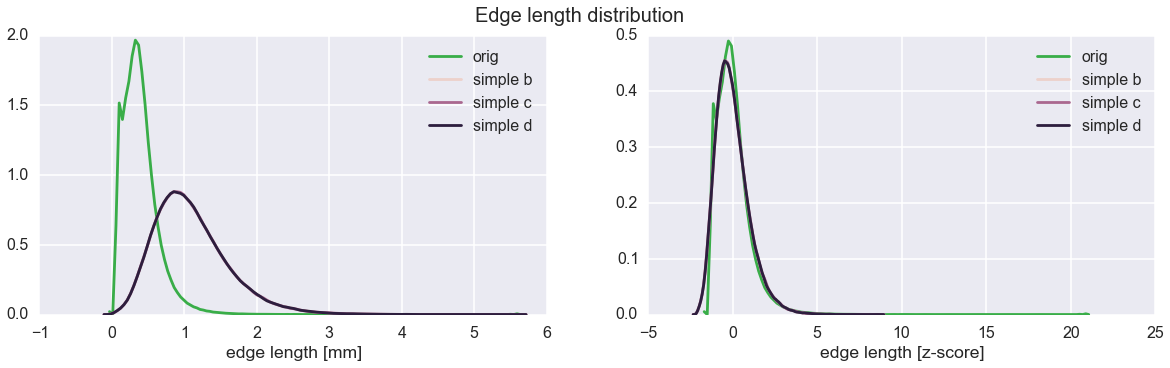

In [31]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Edge length distribution', fontsize=20)
ax1=fig.add_subplot(121)
sns.distplot(edges_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(edges[0], hist = False, label='simple b', color=sns.cubehelix_palette(3)[0])
sns.distplot(edges[1], hist=False, label='simple c', color=sns.cubehelix_palette(3)[1])
sns.distplot(edges[2], hist=False, label='simple d', color=sns.cubehelix_palette(3)[2])
plt.xlabel('edge length [mm]')

ax2=fig.add_subplot(122)
sns.distplot(z_edge_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(z_edges[0], hist = False, label='simple b', color=sns.cubehelix_palette(3)[0])
sns.distplot(z_edges[1], hist=False, label='simple c', color=sns.cubehelix_palette(3)[1])
sns.distplot(z_edges[2], hist=False, label='simple d', color=sns.cubehelix_palette(3)[2])
plt.xlabel('edge length [z-score]')

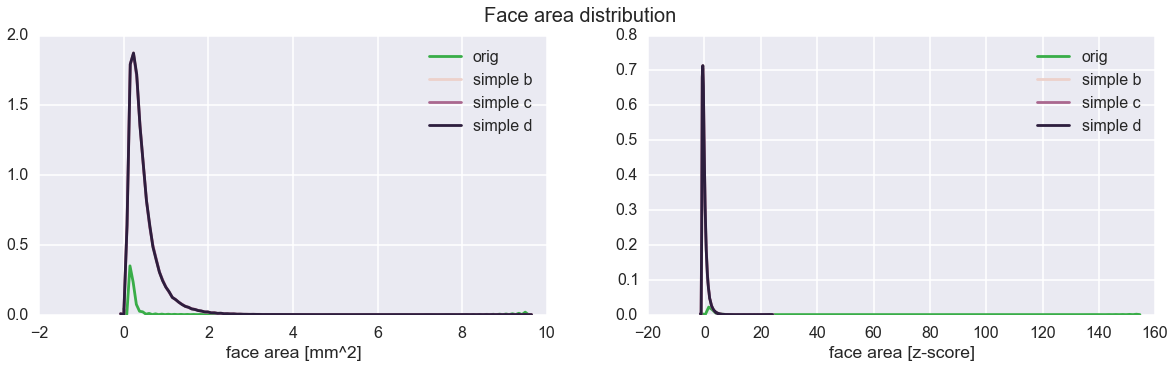

In [32]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Face area distribution', fontsize=20)
ax1=fig.add_subplot(121)
sns.distplot(areas_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(areas[0], hist = False, label='simple b', color=sns.cubehelix_palette(3)[0])
sns.distplot(areas[1], hist=False, label='simple c', color=sns.cubehelix_palette(3)[1])
sns.distplot(areas[2], hist=False, label='simple d', color=sns.cubehelix_palette(3)[2])
plt.xlabel('face area [mm^2]')

ax2=fig.add_subplot(122)
sns.distplot(z_area_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(z_areas[0], hist = False, label='simple b', color=sns.cubehelix_palette(3)[0])
sns.distplot(z_areas[1], hist=False, label='simple c', color=sns.cubehelix_palette(3)[1])
sns.distplot(z_areas[2], hist=False, label='simple d', color=sns.cubehelix_palette(3)[2])
plt.xlabel('face area [z-score]')

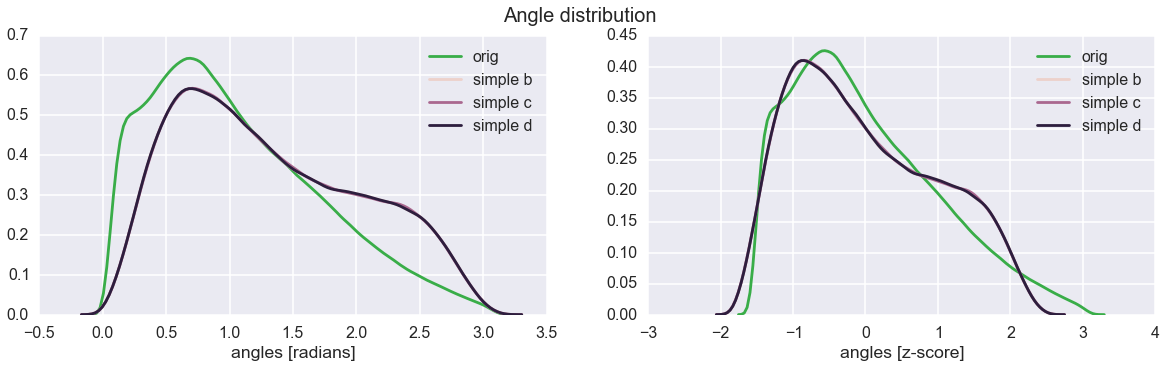

In [33]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Angle distribution', fontsize=20)
ax1=fig.add_subplot(121)
sns.distplot(angles_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(angles[0], hist = False, label='simple b', color=sns.cubehelix_palette(3)[0])
sns.distplot(angles[1], hist=False, label='simple c', color=sns.cubehelix_palette(3)[1])
sns.distplot(angles[2], hist=False, label='simple d', color=sns.cubehelix_palette(3)[2])
plt.xlabel('angles [radians]')

ax2=fig.add_subplot(122)
sns.distplot(z_angle_orig, hist=False, label='orig', color=sns.xkcd_rgb['medium green'])
sns.distplot(z_angles[0], hist = False, label='simple b', color=sns.cubehelix_palette(3)[0])
sns.distplot(z_angles[1], hist=False, label='simple c', color=sns.cubehelix_palette(3)[1])
sns.distplot(z_angles[2], hist=False, label='simple d', color=sns.cubehelix_palette(3)[2])
plt.xlabel('angles [z-score]')